In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd

zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True)


extract_dir = os.path.dirname(zip_path)
csv_path = os.path.join(extract_dir, "jena_climate_2009_2016_extracted", "jena_climate_2009_2016.csv")


if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df.head()


13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


<Axes: xlabel='Date Time'>

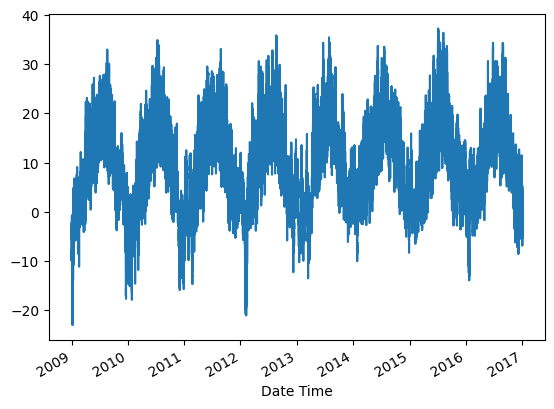

In [ ]:
temp = df['T (degC)']
temp.plot()

In [ ]:
def make_overlapping_windows(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

WINDOW_SIZE = 5

X1, y1 = make_overlapping_windows(temp, WINDOW_SIZE)

X_train1, X_remaining, y_train1, y_remaining = train_test_split(X1, y1, train_size=60000, shuffle=False)


X_val1, X_test1, y_val1, y_test1 = train_test_split(X_remaining, y_remaining, test_size=0.2, shuffle=False)


print(f'X_train1 Shape: {X_train1.shape}, y_train1 Shape: {y_train1.shape}')
print(f'X_val1 Shape: {X_val1.shape}, y_val1 Shape: {y_val1.shape}')
print(f'X_test1 Shape: {X_test1.shape}, y_test1 Shape: {y_test1.shape}')


X_train1 Shape: (60000, 5, 1), y_train1 Shape: (60000,)
X_val1 Shape: (288436, 5, 1), y_val1 Shape: (288436,)
X_test1 Shape: (72110, 5, 1), y_test1 Shape: (72110,)


# LSTM - KERAS

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 61.6256 - root_mean_squared_error: 7.6738 - val_loss: 8.1355 - val_root_mean_squared_error: 2.8523
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 4.9246 - root_mean_squared_error: 2.2065 - val_loss: 2.3244 - val_root_mean_squared_error: 1.5246
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 1.0227 - root_mean_squared_error: 1.0083 - val_loss: 0.8648 - val_root_mean_squared_error: 0.9299
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.2925 - root_mean_squared_error: 0.5401 - val_loss: 0.4117 - val_root_mean_squared_error: 0.6417
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - loss: 0.1302 - root_mean_squared_error: 0.3607 - val_loss: 0.2300 - val_root_mean_squared_error: 0.4796
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.0853 - root_mean_squared_error: 0.2918 - val_loss: 0.1413 - val_root_mean_squared_error: 0.3759
Epoch 7/10
1875/1875 ━━━━━━

2254/2254 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
LSTM Model Metrics:
MAE: 0.1358
RMSE: 0.2233
------------------------------
Naive Baseline Metrics:
MAE: 0.1580
RMSE: 0.2373
------------------------------
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


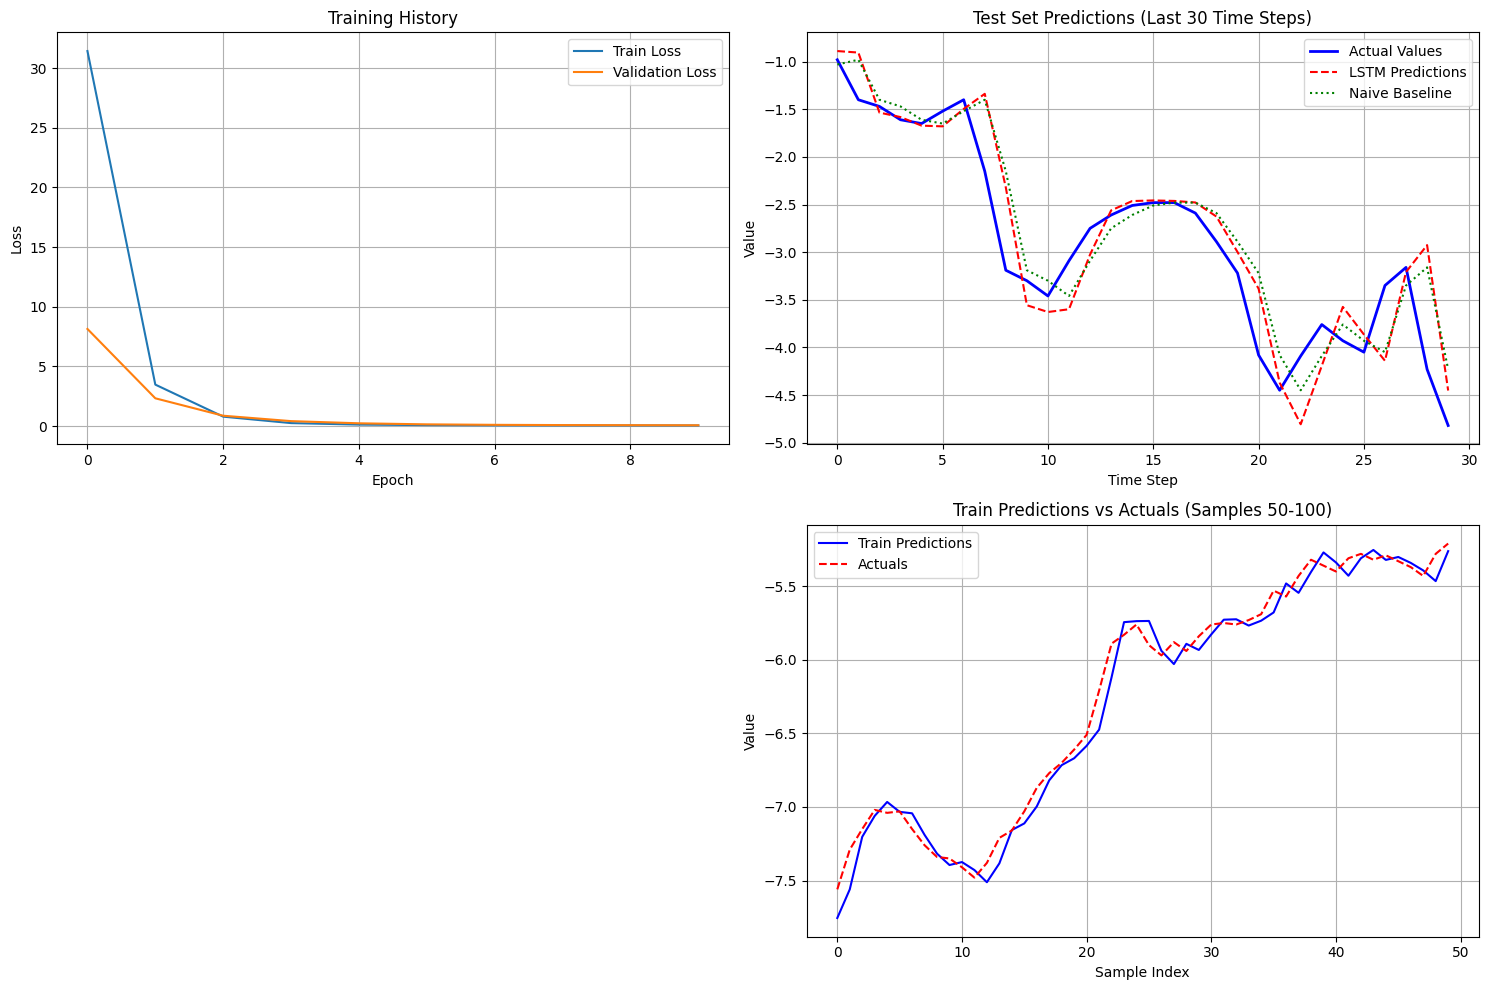

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def naive_forecast(X_test):
    return X_test[:, -1, 0]

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(1, activation='linear'))

model1.summary()

model1.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.0001),
               metrics=[RootMeanSquaredError()])


history = model1.fit(X_train1, y_train1,
                    validation_data=(X_val1, y_val1),
                    epochs=10,
                    verbose=1)


test_predictions = model1.predict(X_test1).flatten()

naive_preds = naive_forecast(X_test1)


def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 30)

print_metrics(y_test1, test_predictions, "LSTM Model")
print_metrics(y_test1, naive_preds, "Naive Baseline")


plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
last_30 = slice(-30, None)
plt.plot(y_test1[last_30], label='Actual Values', color='blue', linewidth=2)
plt.plot(test_predictions[last_30], label='LSTM Predictions', color='red', linestyle='--')
plt.plot(naive_preds[last_30], label='Naive Baseline', color='green', linestyle=':')
plt.title('Test Set Predictions (Last 30 Time Steps)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
train_predictions = model1.predict(X_train1).flatten()
plt.plot(train_predictions[50:100], label='Train Predictions', color='blue')
plt.plot(y_train1[50:100], label='Actuals', color='red', linestyle='--')
plt.title('Train Predictions vs Actuals (Samples 50-100)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

=== Recurrent Layer Visualization ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


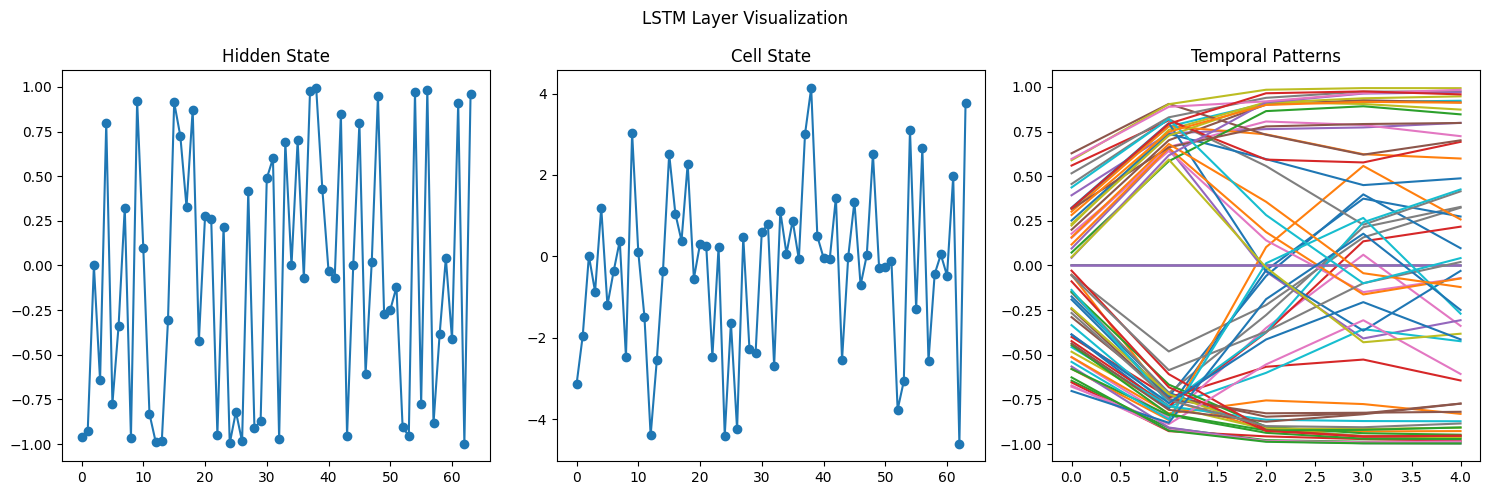


=== Timestep Perturbation Analysis ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


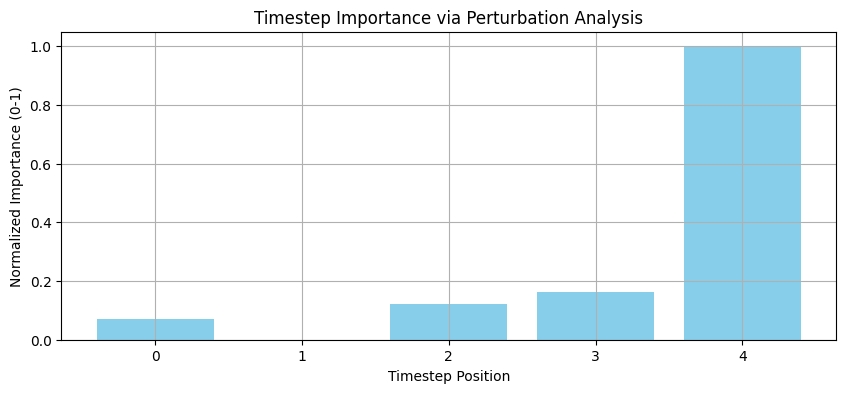

Timestep importance scores: [0.07230089 0.         0.12009565 0.16286127 1.        ]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU
import numpy as np
import matplotlib.pyplot as plt

def visualize_recurrent_layer(trained_model, sample_data, layer_type='lstm'):
    try:
        target_layer = None
        for layer in trained_model.layers:
            if (layer_type == 'lstm' and isinstance(layer, LSTM)) or \
               (layer_type == 'gru' and isinstance(layer, GRU)):
                target_layer = layer
                break

        if not target_layer:
            raise ValueError(f"No {layer_type.upper()} layer found")

        layer_config = target_layer.get_config()
        layer_config.update({
            'return_sequences': True,
            'return_state': True
        })

        if layer_type == 'lstm':
            new_layer = LSTM.from_config(layer_config)
        else:
            new_layer = GRU.from_config(layer_config)

        inputs = Input(shape=trained_model.input_shape[1:])
        outputs = new_layer(inputs)
        temp_model = Model(inputs=inputs, outputs=outputs)


        weights = target_layer.get_weights()
        if weights:
            temp_model.layers[1].set_weights(weights)


        preds = temp_model.predict(sample_data)


        plt.figure(figsize=(15, 5))

        if layer_type == 'lstm':
            full_output, h_state, c_state = preds
            plt.suptitle("LSTM Layer Visualization")

            plt.subplot(1, 3, 1)
            plt.plot(h_state[0], 'o-')
            plt.title("Hidden State")

            plt.subplot(1, 3, 2)
            plt.plot(c_state[0], 'o-')
            plt.title("Cell State")

            plt.subplot(1, 3, 3)
            for i in range(min(64, target_layer.units)):
                plt.plot(full_output[0, :, i], label=f'Neuron {i}') ##full_output=(batch_size, timesteps, units) => bierzemy aktywacje i-tego neuronu w kolejnych krokach czasowych (kroki czasowe=dł okna)
            plt.title("Temporal Patterns")

        else:  # GRU
            full_output, h_state = preds
            plt.suptitle("GRU Layer Visualization")

            plt.subplot(1, 2, 1)
            plt.plot(h_state[0], 'o-')
            plt.title("Hidden State")

            plt.subplot(1, 2, 2)
            for i in range(min(5, target_layer.units)):
                plt.plot(full_output[0, :, i], label=f'Neuron {i}')
            plt.title("Temporal Patterns")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Visualization failed: {str(e)}")

def analyze_timestep_perturbations(model, X, y_true, n_samples=100):
    """
    Po kolei zerujemy każdy krok czasowy w danych wejściowych .

    Sprawdzamy, jak bardzo pogarsza się wynik modelu (wzrost MAE – średni błąd bezwzględny).

    Im większy wpływ wyzerowania danego kroku na wynik → tym ważniejszy ten krok dla modelu.
    """
    original_pred = model.predict(X[:n_samples]).flatten()
    baseline_mae = np.mean(np.abs(y_true[:n_samples] - original_pred))

    importance_scores = []
    for t in range(X.shape[1]):  # for each timestep
        X_perturbed = X[:n_samples].copy()
        X_perturbed[:, t, :] = 0  # zero out this timestep

        perturbed_pred = model.predict(X_perturbed).flatten()
        mae_change = np.mean(np.abs(y_true[:n_samples] - perturbed_pred)) - baseline_mae
        importance_scores.append(mae_change)

    # normalize scores to 0-1 range
    importance_scores = np.array(importance_scores)
    if importance_scores.max() > 0:
        importance_scores = (importance_scores - importance_scores.min()) / \
                          (importance_scores.max() - importance_scores.min())


    plt.figure(figsize=(10, 4))
    plt.bar(range(X.shape[1]), importance_scores, color='skyblue')
    plt.title("Timestep Importance via Perturbation Analysis")
    plt.xlabel("Timestep Position")
    plt.ylabel("Normalized Importance (0-1)")
    plt.xticks(range(X.shape[1]))
    plt.grid(True)
    plt.show()

    return importance_scores


if __name__ == "__main__":

    print("=== Recurrent Layer Visualization ===")
    visualize_recurrent_layer(model1, X_test1[:1], 'lstm')

    print("\n=== Timestep Perturbation Analysis ===")
    if 'y_test1' in locals():
        importance = analyze_timestep_perturbations(model1, X_test1, y_test1)
        print("Timestep importance scores:", importance)
    else:
        print("Skipping perturbation analysis - y_test1 not found")

1. Stan Ukryty (Hidden State):

Jeśli neurony wykazują silną aktywację (>0.5) → specjalizują się w wykrywaniu kluczowych wzorców w danych

Nierównomierny rozkład → sieć selektywnie wykorzystuje neurony, zamiast równomiernie rozkładać obliczenia


2. Stan Komórki (Cell State):

Gwałtowne skoki wartości (np. przy neuronach 15 i 45) → momenty krytyczne, gdy sieć aktualizuje swoją "pamięć długoterminową"

Amplituda oscylacji (-4 do +4) → silna kontrola nad zapominaniem/aktualizacją informacji


3. Wzorce Czasowe (Temporal Patterns):


Niebieski -  (krok 5-10)	- reguje na początkowe sygnały
Pomarańczowy	- późna aktywacja (~krok 30)	- analizuje kontekst końcowy
Zielony	- stała niska aktywność	- stabilizuje obliczenia


Neurony działają jak zespół ekspertów, gdzie każdy specjalizuje się w innej fazie przetwarzania

Brak redundancji: Unikalne wzorce aktywacji sugerują efektywne wykorzystanie zasobów

Czytelna sygnalizacja: Wyraźne różnice czasowe ułatwiają interpretację decyzji modelu

# LSTM - TORCH

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1, Train Loss: 51.4675, Val Loss: 19.9749, Val RMSE: 4.4693
Epoch 2, Train Loss: 8.5496, Val Loss: 5.2721, Val RMSE: 2.2961
Epoch 3, Train Loss: 1.8830, Val Loss: 1.7767, Val RMSE: 1.3329
Epoch 4, Train Loss: 0.5218, Val Loss: 0.7294, Val RMSE: 0.8540
Epoch 5, Train Loss: 0.1978, Val Loss: 0.3582, Val RMSE: 0.5985
Epoch 6, Train Loss: 0.1059, Val Loss: 0.2032, Val RMSE: 0.4508
Epoch 7, Train Loss: 0.0714, Val Loss: 0.1267, Val RMSE: 0.3560
Epoch 8, Train Loss: 0.0562, Val Loss: 0.0902, Val RMSE: 0.3003
Epoch 9, Train Loss: 0.0492, Val Loss: 0.0746, Val RMSE: 0.2732
Epoch 10, Train Loss: 0.0461, Val Loss: 0.0660, Val RMSE: 0.2568
LSTM Model Metrics:
MAE: 0.1407
RMSE: 0.2274
------------------------------
Naive Baseline Metrics:
MAE: 0.1580
RMSE: 0.2373
------------------------------


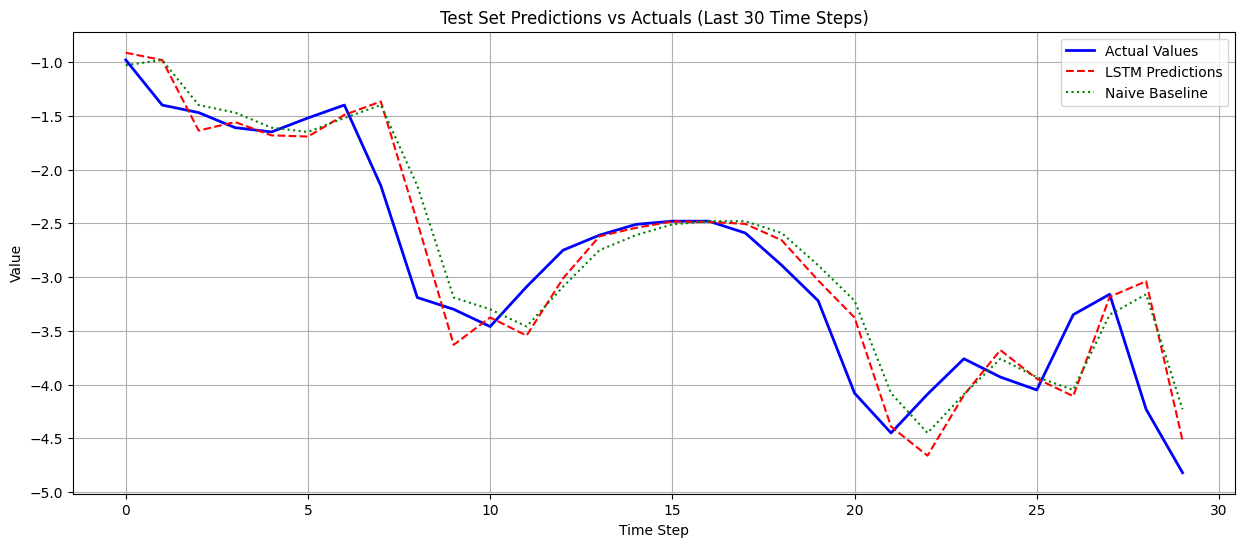

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :] #hidden state of the last time step
        x = self.fc(x)
        return x.squeeze(-1)


def make_overlapping_windows(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


def naive_forecast(X_test):
    return X_test[:, -1, 0]


X1, y1 = make_overlapping_windows(temp, 5)


X_train1, X_remaining, y_train1, y_remaining = train_test_split(
    X1, y1, train_size=60000, shuffle=False)
X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_remaining, y_remaining, test_size=0.2, shuffle=False)


X_train_tensor = torch.FloatTensor(X_train1)
y_train_tensor = torch.FloatTensor(y_train1)
X_val_tensor = torch.FloatTensor(X_val1)
y_val_tensor = torch.FloatTensor(y_val1)
X_test_tensor = torch.FloatTensor(X_test1)
y_test_np = y_test1


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(X_test_tensor, torch.FloatTensor(y_test_np))
test_loader = DataLoader(test_dataset, batch_size=32)


model = LSTMModel()
print(model)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


for epoch in range(10):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)
    val_rmse = torch.sqrt(torch.tensor(val_loss))

    print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')


model.eval()
test_predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.numpy())

test_predictions = np.array(test_predictions)


naive_preds = naive_forecast(X_test1)


def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 30)

print_metrics(y_test_np, test_predictions, "LSTM Model")
print_metrics(y_test_np, naive_preds, "Naive Baseline")


plt.figure(figsize=(15, 6))
last_30 = slice(-30, None)


plt.plot(y_test_np[last_30], label='Actual Values', color='blue', linewidth=2)
plt.plot(test_predictions[last_30], label='LSTM Predictions', color='red', linestyle='--')
plt.plot(naive_preds[last_30], label='Naive Baseline', color='green', linestyle=':')

plt.legend()
plt.title('Test Set Predictions vs Actuals (Last 30 Time Steps)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()


# GRU - KERAS

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 75.5564 - root_mean_squared_error: 8.4801 - val_loss: 12.4088 - val_root_mean_squared_error: 3.5226
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - loss: 5.8851 - root_mean_squared_error: 2.4141 - val_loss: 3.6654 - val_root_mean_squared_error: 1.9145
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - loss: 1.4160 - root_mean_squared_error: 1.1848 - val_loss: 1.3750 - val_root_mean_squared_error: 1.1726
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - loss: 0.4083 - root_mean_squared_error: 0.6360 - val_loss: 0.5967 - val_root_mean_squared_error: 0.7725
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 0.1457 - root_mean_squared_error: 0.3812 - val_loss: 0.3171 - val_root_mean_squared_error: 0.5632
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0813 - root_mean_squared_error: 0.2849 - val_loss: 0.1879 - val_root_mean_squared_error: 0.4335
Epoch 7/10
1875/1875 ━━━━━

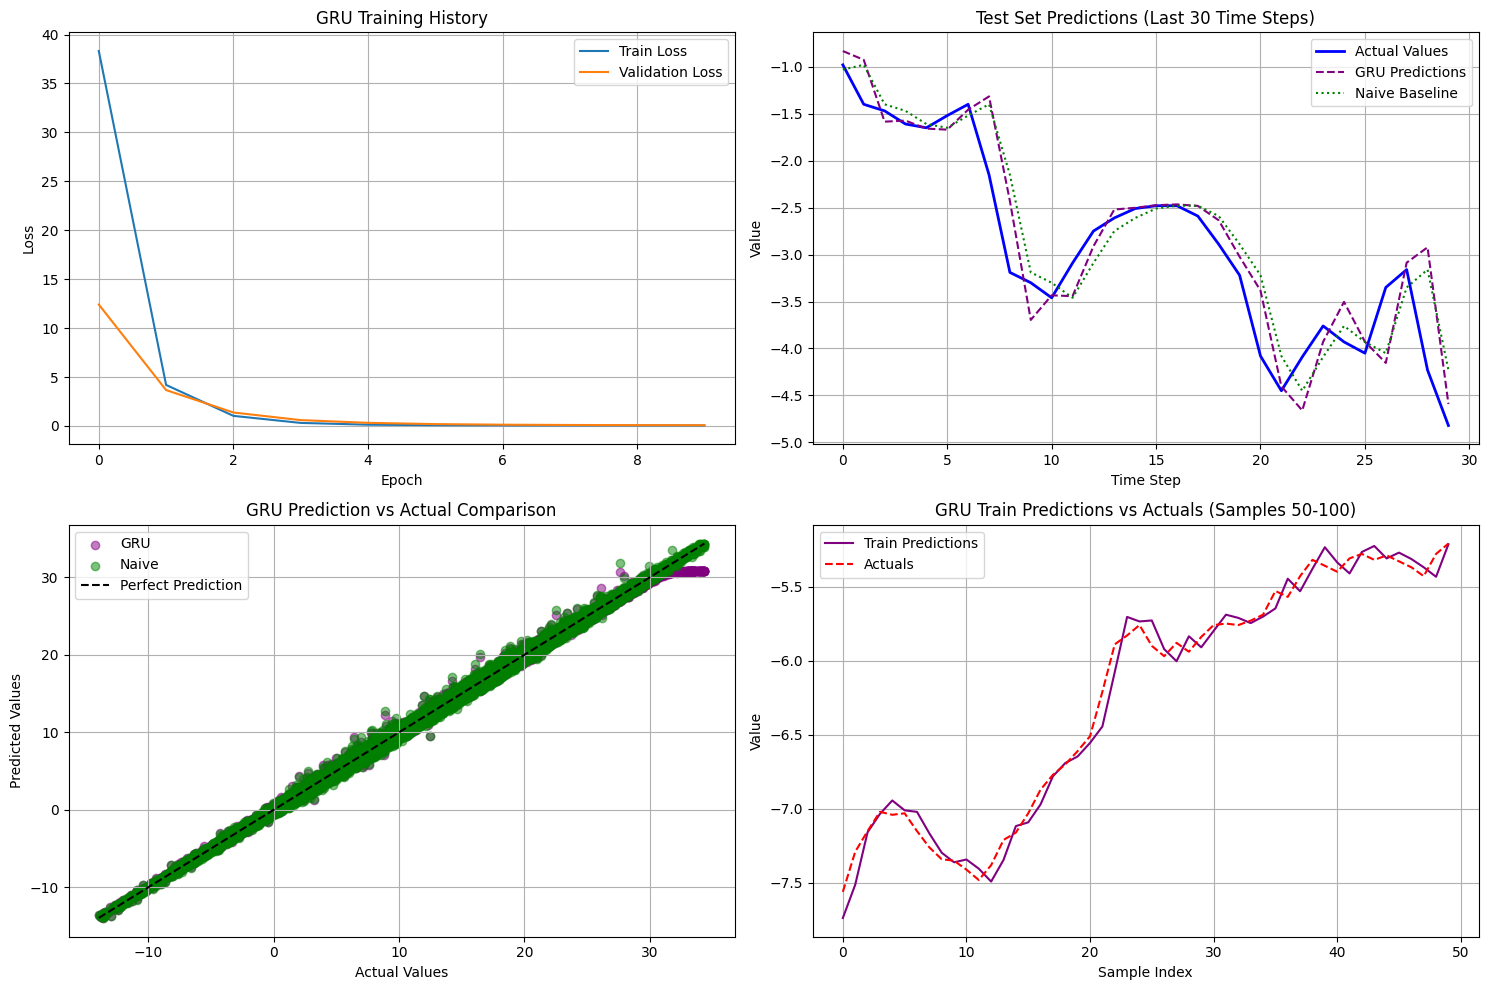

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def naive_forecast(X_test):
    return X_test[:, -1, 0]


model_gru = Sequential()
model_gru.add(InputLayer((5, 1)))
model_gru.add(GRU(64))
model_gru.add(Dense(1, activation='linear'))

model_gru.summary()


model_gru.compile(loss=MeanSquaredError(),
                 optimizer=Adam(learning_rate=0.0001),
                 metrics=[RootMeanSquaredError()])


history_gru = model_gru.fit(X_train1, y_train1,
                          validation_data=(X_val1, y_val1),
                          epochs=10,
                          verbose=1)


test_predictions_gru = model_gru.predict(X_test1).flatten()


naive_preds = naive_forecast(X_test1)


def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 30)

print_metrics(y_test1, test_predictions_gru, "GRU Model")
print_metrics(y_test1, naive_preds, "Naive Baseline")


plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
last_30 = slice(-30, None)
plt.plot(y_test1[last_30], label='Actual Values', color='blue', linewidth=2)
plt.plot(test_predictions_gru[last_30], label='GRU Predictions', color='purple', linestyle='--')
plt.plot(naive_preds[last_30], label='Naive Baseline', color='green', linestyle=':')
plt.title('Test Set Predictions (Last 30 Time Steps)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.scatter(y_test1, test_predictions_gru, alpha=0.5, label='GRU', color='purple')
plt.scatter(y_test1, naive_preds, alpha=0.5, label='Naive', color='green')
plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)],
         'k--', label='Perfect Prediction')
plt.title('GRU Prediction vs Actual Comparison')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
train_predictions_gru = model_gru.predict(X_train1).flatten()
plt.plot(train_predictions_gru[50:100], label='Train Predictions', color='purple')
plt.plot(y_train1[50:100], label='Actuals', color='red', linestyle='--')
plt.title('GRU Train Predictions vs Actuals (Samples 50-100)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

=== Recurrent Layer Visualization ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


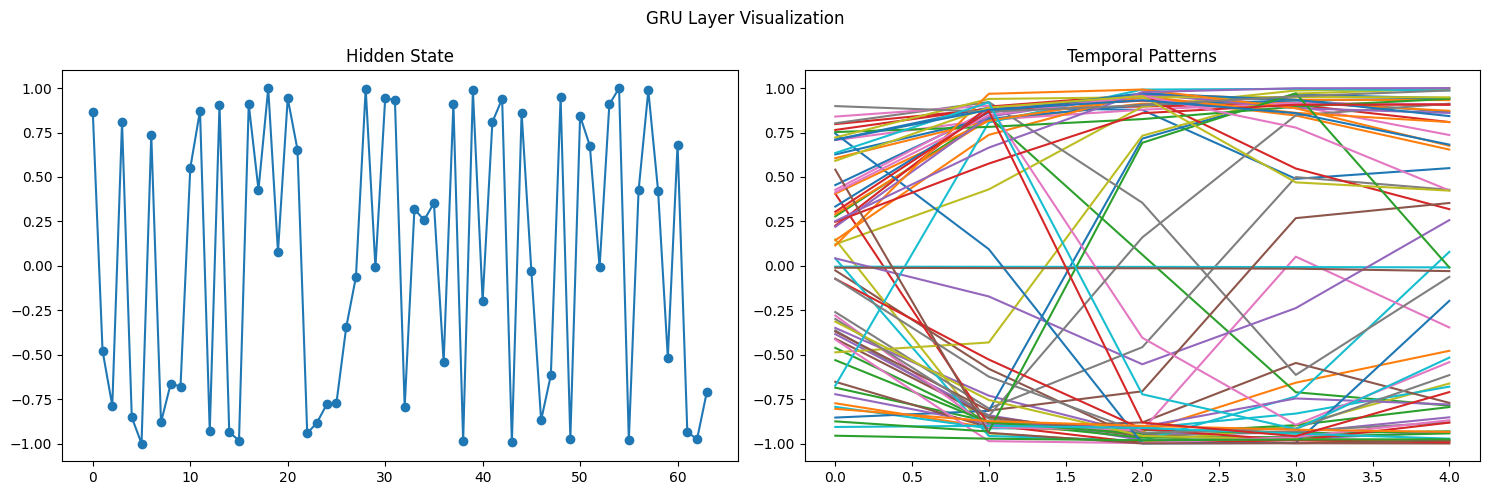


=== Timestep Perturbation Analysis ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


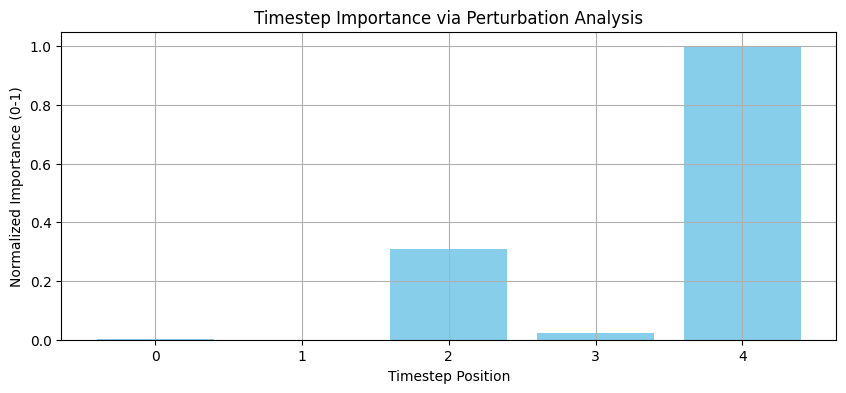

Timestep importance scores: [0.00375584 0.         0.30787671 0.02416699 1.        ]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU
import numpy as np
import matplotlib.pyplot as plt

def visualize_recurrent_layer(trained_model, sample_data, layer_type='lstm'):
    try:
        target_layer = None
        for layer in trained_model.layers:
            if (layer_type == 'lstm' and isinstance(layer, LSTM)) or \
               (layer_type == 'gru' and isinstance(layer, GRU)):
                target_layer = layer
                break

        if not target_layer:
            raise ValueError(f"No {layer_type.upper()} layer found")

        layer_config = target_layer.get_config()
        layer_config.update({
            'return_sequences': True,
            'return_state': True
        })

        if layer_type == 'lstm':
            new_layer = LSTM.from_config(layer_config)
        else:
            new_layer = GRU.from_config(layer_config)


        inputs = Input(shape=trained_model.input_shape[1:])
        outputs = new_layer(inputs)
        temp_model = Model(inputs=inputs, outputs=outputs)

        weights = target_layer.get_weights()
        if weights:
            temp_model.layers[1].set_weights(weights)

        preds = temp_model.predict(sample_data)

        plt.figure(figsize=(15, 5))

        if layer_type == 'lstm':
            full_output, h_state, c_state = preds
            plt.suptitle("LSTM Layer Visualization")

            plt.subplot(1, 3, 1)
            plt.plot(h_state[0], 'o-')
            plt.title("Hidden State")

            plt.subplot(1, 3, 2)
            plt.plot(c_state[0], 'o-')
            plt.title("Cell State")

            plt.subplot(1, 3, 3)
            for i in range(min(10, target_layer.units)):
                plt.plot(full_output[0, :, i], label=f'Neuron {i}') #full_output=(batch_size, timesteps, units) => bierzemy aktywacje i-tego neuronu w kolejnych krokach czasowych
            plt.title("Temporal Patterns")

        else:  # GRU
            full_output, h_state = preds
            plt.suptitle("GRU Layer Visualization")

            plt.subplot(1, 2, 1)
            plt.plot(h_state[0], 'o-')
            plt.title("Hidden State") #GRU ma tylko hidden-state, bo to on łączy zapamiętywanie i zapominanie

            plt.subplot(1, 2, 2)
            for i in range(min(64, target_layer.units)):
                plt.plot(full_output[0, :, i], label=f'Neuron {i}')
            plt.title("Temporal Patterns")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Visualization failed: {str(e)}")

def analyze_timestep_perturbations(model, X, y_true, n_samples=100):
    """
    Po kolei zerujemy każdy krok czasowy w danych wejściowych .

    Sprawdzamy, jak bardzo pogarsza się wynik modelu (wzrost MAE – średni błąd bezwzględny).

    Im większy wpływ wyzerowania danego kroku na wynik → tym ważniejszy ten krok dla modelu.
    """
    original_pred = model.predict(X[:n_samples]).flatten()
    baseline_mae = np.mean(np.abs(y_true[:n_samples] - original_pred))

    importance_scores = []
    for t in range(X.shape[1]):  # for each timestep
        X_perturbed = X[:n_samples].copy()
        X_perturbed[:, t, :] = 0  # zero out this timestep

        perturbed_pred = model.predict(X_perturbed).flatten()
        mae_change = np.mean(np.abs(y_true[:n_samples] - perturbed_pred)) - baseline_mae
        importance_scores.append(mae_change)

    # normalize scores to 0-1 range
    importance_scores = np.array(importance_scores)
    if importance_scores.max() > 0:
        importance_scores = (importance_scores - importance_scores.min()) / \
                          (importance_scores.max() - importance_scores.min())


    plt.figure(figsize=(10, 4))
    plt.bar(range(X.shape[1]), importance_scores, color='skyblue')
    plt.title("Timestep Importance via Perturbation Analysis")
    plt.xlabel("Timestep Position")
    plt.ylabel("Normalized Importance (0-1)")
    plt.xticks(range(X.shape[1]))
    plt.grid(True)
    plt.show()

    return importance_scores


if __name__ == "__main__":

    print("=== Recurrent Layer Visualization ===")
    visualize_recurrent_layer(model_gru, X_test1[:1], 'gru')   # For GRU

    print("\n=== Timestep Perturbation Analysis ===")
    if 'y_test1' in locals():
        importance = analyze_timestep_perturbations(model_gru, X_test1, y_test1)
        print("Timestep importance scores:", importance)
    else:
        print("Skipping perturbation analysis - y_test1 not found")

# GRU - TORCH

GRUModel(
  (gru): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1, Train Loss: 47.3404, Val Loss: 21.1980, Val RMSE: 4.6041
Epoch 2, Train Loss: 7.3733, Val Loss: 5.5660, Val RMSE: 2.3592
Epoch 3, Train Loss: 1.6607, Val Loss: 1.9069, Val RMSE: 1.3809
Epoch 4, Train Loss: 0.4497, Val Loss: 0.7885, Val RMSE: 0.8880
Epoch 5, Train Loss: 0.1618, Val Loss: 0.3958, Val RMSE: 0.6291
Epoch 6, Train Loss: 0.0887, Val Loss: 0.2280, Val RMSE: 0.4774
Epoch 7, Train Loss: 0.0642, Val Loss: 0.1506, Val RMSE: 0.3881
Epoch 8, Train Loss: 0.0537, Val Loss: 0.1081, Val RMSE: 0.3289
Epoch 9, Train Loss: 0.0490, Val Loss: 0.0888, Val RMSE: 0.2981
Epoch 10, Train Loss: 0.0464, Val Loss: 0.0781, Val RMSE: 0.2794
GRU Model Metrics:
MAE: 0.1400
RMSE: 0.2441
------------------------------
Naive Baseline Metrics:
MAE: 0.1580
RMSE: 0.2373
------------------------------


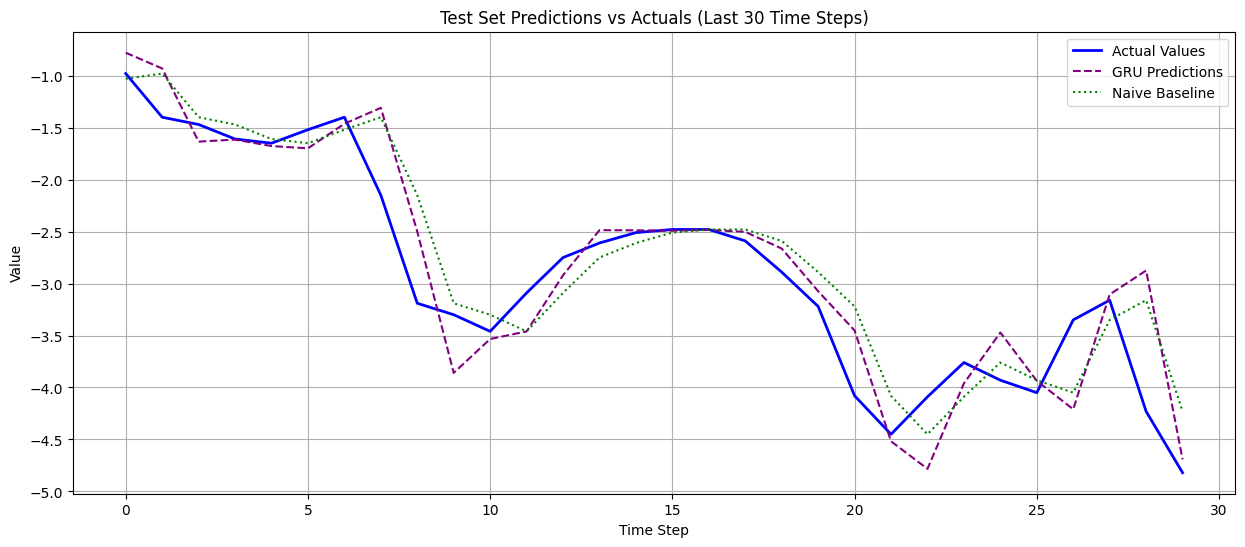

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x.squeeze(-1)

def make_overlapping_windows(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

def naive_forecast(X_test):
    return X_test[:, -1, 0]

X1, y1 = make_overlapping_windows(temp, 5)

X_train1, X_remaining, y_train1, y_remaining = train_test_split(
    X1, y1, train_size=60000, shuffle=False)
X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_remaining, y_remaining, test_size=0.2, shuffle=False)

X_train_tensor = torch.FloatTensor(X_train1)
y_train_tensor = torch.FloatTensor(y_train1)
X_val_tensor = torch.FloatTensor(X_val1)
y_val_tensor = torch.FloatTensor(y_val1)
X_test_tensor = torch.FloatTensor(X_test1)
y_test_np = y_test1

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(X_test_tensor, torch.FloatTensor(y_test_np))
test_loader = DataLoader(test_dataset, batch_size=32)

model = GRUModel()
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)
    val_rmse = torch.sqrt(torch.tensor(val_loss))

    print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')

model.eval()
test_predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.numpy())

test_predictions = np.array(test_predictions)
naive_preds = naive_forecast(X_test1)

def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 30)

print_metrics(y_test_np, test_predictions, "GRU Model")
print_metrics(y_test_np, naive_preds, "Naive Baseline")

plt.figure(figsize=(15, 6))
last_30 = slice(-30, None)
plt.plot(y_test_np[last_30], label='Actual Values', color='blue', linewidth=2)
plt.plot(test_predictions[last_30], label='GRU Predictions', color='purple', linestyle='--')
plt.plot(naive_preds[last_30], label='Naive Baseline', color='green', linestyle=':')
plt.legend()
plt.title('Test Set Predictions vs Actuals (Last 30 Time Steps)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

#HYPERPARAMETERS - TORCH


Training LSTM with config: {'units': 64, 'layers': 1, 'lr': 0.0001, 'batch_size': 32}
Epoch 1, Val Loss: 17.6550, Val RMSE: 4.2018
Epoch 2, Val Loss: 4.6079, Val RMSE: 2.1466
Epoch 3, Val Loss: 1.5536, Val RMSE: 1.2464
Epoch 4, Val Loss: 0.6380, Val RMSE: 0.7987
Epoch 5, Val Loss: 0.3158, Val RMSE: 0.5619
Epoch 6, Val Loss: 0.1755, Val RMSE: 0.4190
Epoch 7, Val Loss: 0.1104, Val RMSE: 0.3322
Epoch 8, Val Loss: 0.0816, Val RMSE: 0.2856
Epoch 9, Val Loss: 0.0718, Val RMSE: 0.2679
Epoch 10, Val Loss: 0.0622, Val RMSE: 0.2494

Training LSTM with config: {'units': 128, 'layers': 1, 'lr': 0.0001, 'batch_size': 32}
Epoch 1, Val Loss: 4.4284, Val RMSE: 2.1044
Epoch 2, Val Loss: 1.0279, Val RMSE: 1.0139
Epoch 3, Val Loss: 0.4011, Val RMSE: 0.6333
Epoch 4, Val Loss: 0.1999, Val RMSE: 0.4471
Epoch 5, Val Loss: 0.1139, Val RMSE: 0.3375
Epoch 6, Val Loss: 0.0780, Val RMSE: 0.2793
Epoch 7, Val Loss: 0.0612, Val RMSE: 0.2473
Epoch 8, Val Loss: 0.0577, Val RMSE: 0.2402
Epoch 9, Val Loss: 0.0527, Val 

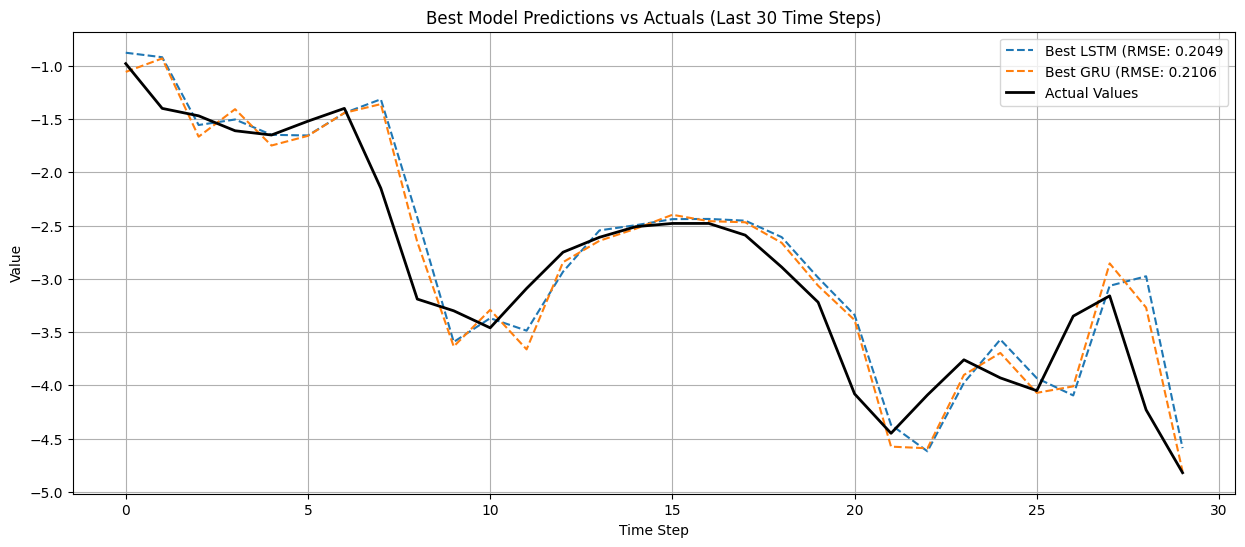

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

configs = {
    'LSTM': [
        {'units': 64, 'layers': 1, 'lr': 0.0001, 'batch_size': 32},
        {'units': 128, 'layers': 1, 'lr': 0.0001, 'batch_size': 32},
        {'units': 64, 'layers': 2, 'lr': 0.0001, 'batch_size': 32}
    ],
    'GRU': [
        {'units': 64, 'layers': 1, 'lr': 0.0001, 'batch_size': 32},
        {'units': 64, 'layers': 1, 'lr': 0.001, 'batch_size': 32},
        {'units': 64, 'layers': 1, 'lr': 0.0001, 'batch_size': 64}
    ]
}

class RecurrentModel(nn.Module):
    def __init__(self, model_type, units, layers):
        super(RecurrentModel, self).__init__()
        self.model_type = model_type
        self.layers = layers

        if model_type == 'LSTM':
            self.rnn1 = nn.LSTM(input_size=1, hidden_size=units, batch_first=True)
            if layers > 1:
                self.rnn2 = nn.LSTM(input_size=units, hidden_size=units, batch_first=True)
        else:  # GRU
            self.rnn1 = nn.GRU(input_size=1, hidden_size=units, batch_first=True)
            if layers > 1:
                self.rnn2 = nn.GRU(input_size=units, hidden_size=units, batch_first=True)

        self.fc = nn.Linear(units, 1)

    def forward(self, x):
        if self.model_type == 'LSTM':
            x, _ = self.rnn1(x)
            if self.layers > 1:
                x, _ = self.rnn2(x)
        else:  # GRU
            x, _ = self.rnn1(x)
            if self.layers > 1:
                x, _ = self.rnn2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x.squeeze(-1)

def train_evaluate_model(model_type, config):
    print(f"\nTraining {model_type} with config: {config}")

    model = RecurrentModel(model_type, config['units'], config['layers'])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    for epoch in range(10):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        val_loss /= len(val_loader)
        val_rmse = torch.sqrt(torch.tensor(val_loss))
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')

    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_predictions.extend(outputs.numpy())

    test_predictions = np.array(test_predictions)
    mae = mean_absolute_error(y_test_np, test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test_np, test_predictions))

    return {'mae': mae, 'rmse': rmse, 'predictions': test_predictions}


X1, y1 = make_overlapping_windows(temp, 5)
X_train1, X_remaining, y_train1, y_remaining = train_test_split(X1, y1, train_size=60000, shuffle=False)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_remaining, y_remaining, test_size=0.2, shuffle=False)

X_train_tensor = torch.FloatTensor(X_train1)
y_train_tensor = torch.FloatTensor(y_train1)
X_val_tensor = torch.FloatTensor(X_val1)
y_val_tensor = torch.FloatTensor(y_val1)
X_test_tensor = torch.FloatTensor(X_test1)
y_test_np = y_test1

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, torch.FloatTensor(y_test_np))


results = {}
for model_type in ['LSTM', 'GRU']:
    results[model_type] = []
    for config in configs[model_type]:
        results[model_type].append(train_evaluate_model(model_type, config))


print("\n=== Results Summary ===")
for model_type in ['LSTM', 'GRU']:
    print(f"\n{model_type} Configurations:")
    for i, (config, result) in enumerate(zip(configs[model_type], results[model_type])):
        print(f"Config {i+1}: {config}")
        print(f"  Test MAE: {result['mae']:.4f}, Test RMSE: {result['rmse']:.4f}")


plt.figure(figsize=(15, 6))
last_30 = slice(-30, None)

for model_type in ['LSTM', 'GRU']:
    best_idx = np.argmin([r['rmse'] for r in results[model_type]])
    best_pred = results[model_type][best_idx]['predictions']
    plt.plot(best_pred[last_30], '--', label=f'Best {model_type} (RMSE: {results[model_type][best_idx]["rmse"]:.4f}')

plt.plot(y_test_np[last_30], label='Actual Values', color='black', linewidth=2)
plt.legend()
plt.title('Best Model Predictions vs Actuals (Last 30 Time Steps)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

#HYPERPARAMETERS - KERAS


Training LSTM with config: {'units': 128, 'layers': 1, 'lr': 0.0001, 'batch_size': 16}
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 76s 20ms/step - loss: 24.0150 - root_mean_squared_error: 4.5177 - val_loss: 0.6251 - val_root_mean_squared_error: 0.7907
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 0.2076 - root_mean_squared_error: 0.4525 - val_loss: 0.1551 - val_root_mean_squared_error: 0.3939
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 112s 28ms/step - loss: 0.0805 - root_mean_squared_error: 0.2833 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2772
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 119s 22ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2485
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 106s 28ms/step - loss: 0.0478 - root_mean_squared_error: 0.2185 - val_loss: 0.0578 - val_root_mean_squared_error: 0.2405
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 111s 20ms/step - loss: 0.0469 - root_mean_squared_error:

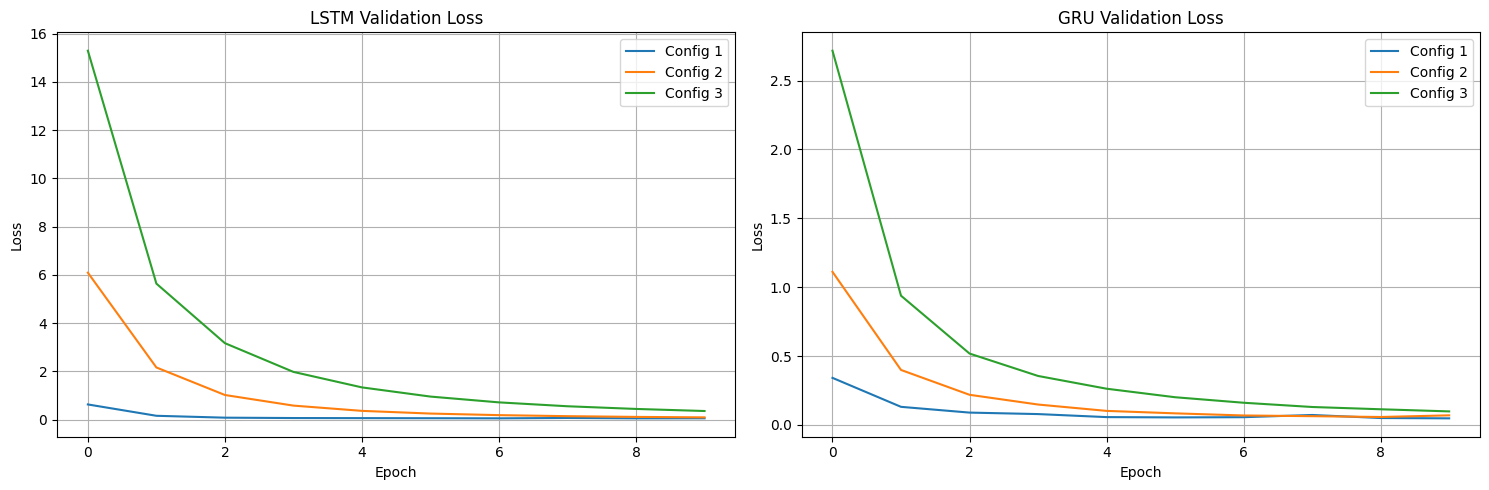

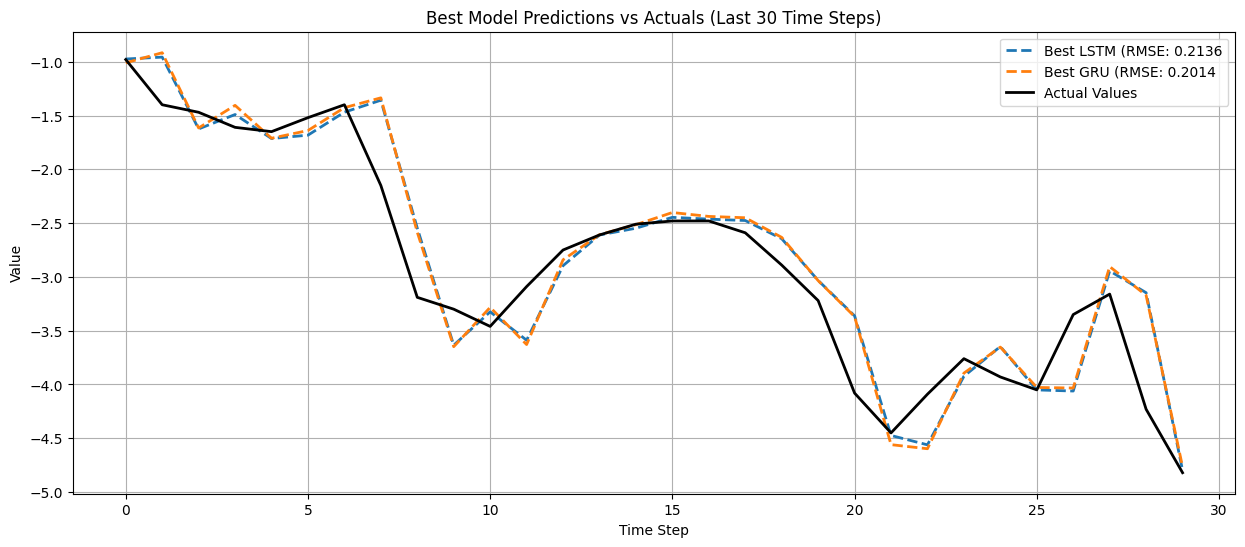

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# experiment configurations - batches
configs = {
    'LSTM': [
        {'units': 128, 'layers': 1, 'lr': 0.0001, 'batch_size': 16},
        {'units': 128, 'layers': 1, 'lr': 0.0001, 'batch_size': 64},
        {'units': 128, 'layers': 1, 'lr': 0.0001, 'batch_size': 128}
    ],
    'GRU': [
        {'units': 64, 'layers': 1, 'lr': 0.001, 'batch_size': 32},
        {'units': 64, 'layers': 1, 'lr': 0.001, 'batch_size': 64},
        {'units': 64, 'layers': 1, 'lr': 0.001, 'batch_size': 128}
    ]
}

def build_model(model_type, units, layers):
    model = Sequential()
    model.add(InputLayer((5, 1)))

    if model_type == 'LSTM':
        if layers == 1:
            model.add(LSTM(units))
        else:
            model.add(LSTM(units, return_sequences=True))
            model.add(LSTM(units))
    else:  # GRU
        if layers == 1:
            model.add(GRU(units))
        else:
            model.add(GRU(units, return_sequences=True))
            model.add(GRU(units))

    model.add(Dense(1, activation='linear'))
    return model

def train_evaluate_model(model_type, config):
    print(f"\nTraining {model_type} with config: {config}")

    model = build_model(model_type, config['units'], config['layers'])
    model.compile(loss=MeanSquaredError(),
                optimizer=Adam(learning_rate=config['lr']),
                metrics=[RootMeanSquaredError()])

    history = model.fit(X_train1, y_train1,
                      validation_data=(X_val1, y_val1),
                      epochs=10,
                      batch_size=config['batch_size'],
                      verbose=1)

    test_predictions = model.predict(X_test1).flatten()
    mae = mean_absolute_error(y_test1, test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))

    return {
        'history': history.history,
        'mae': mae,
        'rmse': rmse,
        'predictions': test_predictions,
        'model': model
    }


X1, y1 = make_overlapping_windows(temp, 5)
X_train1, X_remaining, y_train1, y_remaining = train_test_split(
    X1, y1, train_size=60000, shuffle=False)
X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_remaining, y_remaining, test_size=0.2, shuffle=False)


results = {}
for model_type in ['LSTM', 'GRU']:
    results[model_type] = []
    for config in configs[model_type]:
        results[model_type].append(train_evaluate_model(model_type, config))


print("\n=== Results Summary ===")
for model_type in ['LSTM', 'GRU']:
    print(f"\n{model_type} Configurations:")
    for i, (config, result) in enumerate(zip(configs[model_type], results[model_type])):
        print(f"Config {i+1}: {config}")
        print(f"  Test MAE: {result['mae']:.4f}")
        print(f"  Test RMSE: {result['rmse']:.4f}")


plt.figure(figsize=(15, 5))
for i, model_type in enumerate(['LSTM', 'GRU']):
    plt.subplot(1, 2, i+1)
    for j, result in enumerate(results[model_type]):
        plt.plot(result['history']['val_loss'], label=f"Config {j+1}")
    plt.title(f'{model_type} Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 6))
last_30 = slice(-30, None)

for model_type in ['LSTM', 'GRU']:
    best_idx = np.argmin([r['rmse'] for r in results[model_type]])
    best_pred = results[model_type][best_idx]['predictions']
    plt.plot(best_pred[last_30], '--', linewidth=2,
             label=f'Best {model_type} (RMSE: {results[model_type][best_idx]["rmse"]:.4f}')

plt.plot(y_test1[last_30], label='Actual Values', color='black', linewidth=2)
plt.legend()
plt.title('Best Model Predictions vs Actuals (Last 30 Time Steps)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# EXPLANATIONS - above